In [1]:
# IPython magic tools
%load_ext autoreload
%autoreload 2

from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns
import os

# Plotting and data managing libraries
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = r'Z:\scratch\vr-foraging\data'
data_path = r'../../../data/'
results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\experiments\batch 4 - manipulating cost of travelling and global statistics\results'

# Modelling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.feature_selection import RFE, RFECV

# Statistical tools
from scipy.stats import ttest_1samp

In [2]:
def grid_search(X_mouse_scaled, y_mouse):
                    # Define the parameter grid
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Initialize the logistic regression model
    log_reg = LogisticRegression()

    # Initialize GridSearchCV
    grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

    # Fit GridSearchCV
    grid_search.fit(X_mouse_scaled, y_mouse)

    # Get the best parameter
    best_C = grid_search.best_params_['C']
    print(f"The best value for C is: {best_C}")

    # Get the best score
    best_score = grid_search.best_score_
    print(f"The best cross-validation score is: {best_score:.2f}")

    # Perform 5-fold cross-validation
    log_reg = LogisticRegression(C=best_C)
    
    return best_C

In [7]:
def calculate_metrics(metrics_list, y_mouse, y_pred):    # Calculate confusion matrix (TP, TN, FP, FN)
    """
    Calculate various classification metrics and append them to the provided metrics list.
    Parameters:
    metrics_list (list): A list to which the calculated metrics dictionary will be appended.
    y_mouse (array-like): True labels.
    y_pred (array-like): Predicted labels.
    Returns:
    list: The updated metrics list with the metrics dictionary for the current fold.
    
    The metrics dictionary contains the following keys:
    - "Accuracy 0": Accuracy for class 0 (negative class).
    - "Precision 0": Precision for class 0 (negative class).
    - "Recall 0": Recall for class 0 (negative class).
    - "F1 Score 0": F1 score for class 0 (negative class).
    - "Accuracy 1": Accuracy for class 1 (positive class).
    - "Precision 1": Precision for class 1 (positive class).
    - "Recall 1": Recall for class 1 (positive class).
    - "F1 Score 1": F1 score for class 1 (positive class).
    - "TN": True negatives.
    - "FP": False positives.
    - "FN": False negatives.
    - "TP": True positives.
    """
    
    cm = confusion_matrix(y_mouse, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    
    # Calculate metrics for class 0 (negative class)
    precision_0 = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall_0 = TN / (TN + FN) if (TN + FN) > 0 else 0
    f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    accuracy_0 = (TN) / (TN + FP)  # Proportion of predictions that were `0`
    
    # Calculate metrics for class 1 (positive class)
    precision_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    recall_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    accuracy_1 = (TP) / (TP + FN)  # Proportion of predictions that were `1`
    
    # Collect the metrics for this fold as a dictionary
    fold_metrics = {
        "Accuracy 0": accuracy_0,
        "Precision 0": precision_0,
        "Recall 0": recall_0,
        "F1 Score 0": f1_0,
        "Accuracy 1": accuracy_1,
        "Precision 1": precision_1,
        "Recall 1": recall_1,
        "F1 Score 1": f1_1,
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "TP": TP
    }
    
    # Append the metrics dictionary to the list
    metrics_list.append(fold_metrics)
    return metrics_list

In [56]:
def plotting_roc_curve(y_probs, y_mouse, plot=False):
    # Assuming log_reg is your trained logistic regression model
    # and X_mouse_scaled is your test data (or any data to predict on)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_mouse, y_probs)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Find the best threshold (maximizing Youden's J statistic)
    # J = TPR - FPR
    j_scores = tpr - fpr
    best_threshold_index = np.argmax(j_scores)
    best_threshold = thresholds[best_threshold_index]

    if plot:
        # Plot ROC curve
        plt.figure(figsize=(5, 5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random classifier (diagonal line)
        plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label=f'Best threshold = {best_threshold:.2f}')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        sns.despine()
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    print(f"Best threshold: {best_threshold}")
    print(f"ROC AUC: {roc_auc:.2f}")
    return best_threshold

In [245]:
def logistic_session(summary_df, 
                              use_polynomial_features=True, 
                              orig_features = ['reward_probability', 'consecutive_failures', 'visit_number', 'cumulative_rewards', 'active_patch']):

    # Initialize dataframes to store weights and cross-validation results
    weights_df = pd.DataFrame(columns=['regressors', 'weights', 'mouse', 'session'])
    cv_results_df = pd.DataFrame()
    metrics_list = []
    new_mouse_df = pd.DataFrame()
    
    for (mouse, session), mouse_df in summary_df.groupby(['mouse', 'session']):
        print(f"Mouse: {mouse}, Session: {session}")
        
        # Select features and target variable
        X_mouse = mouse_df[orig_features]
        y_mouse = mouse_df['has_choice'].astype(int)
            
        # Define the pipeline
        if use_polynomial_features:
            poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
            X_mouse = poly.fit_transform(X_mouse)
            features = poly.get_feature_names_out()
        else:
            features = orig_features
        
        # Standardize the features
        scaler = StandardScaler()
        X_mouse_scaled = scaler.fit_transform(X_mouse)
        
        # Perform 5-fold cross-validation
        if len(X_mouse_scaled) < 20:
            continue

        cv = StratifiedKFold(n_splits=5, shuffle=True)  # random_state ensures reproducibility
        log_reg = LogisticRegression(class_weight='balanced')
        cv_scores = cross_val_score(log_reg, X_mouse_scaled, y_mouse, cv=cv, scoring='roc_auc')

        # Fit the logistic regression model using formula
        log_reg.fit(X_mouse_scaled, y_mouse)

        # Predict class labels (0 or 1)
        y_pred = log_reg.predict(X_mouse_scaled)
        mouse_df['y_pred'] = y_pred
        
        y_probs = log_reg.predict_proba(X_mouse_scaled)[:, 1]
        mouse_df['y_pred_prob'] = y_probs
        
        best_threshold = plotting_roc_curve(y_probs, y_mouse)
        
        y_pred_adjusted = (y_probs >= best_threshold).astype(int)
        mouse_df['y_pred_adjusted'] = y_pred_adjusted
        
        metrics_list = calculate_metrics(metrics_list, y_mouse, y_pred_adjusted)
        
        feature_weights = pd.Series(log_reg.coef_[0], index=features)
        feature_weights = feature_weights.reset_index()
        feature_weights.rename(columns={'index': 'regressors', 0: 'weights'}, inplace=True)
        feature_weights['mouse'] = mouse
        feature_weights['session'] = session

        # Append the weights and cv scores to the respective dataframes
        weights_df = pd.concat([weights_df, feature_weights], ignore_index=True)
        cv_results_df = pd.concat([cv_results_df, pd.DataFrame({'session': [session], 'mouse': [mouse], 'cv_std': [cv_scores.std()],
                                                                'cv_score': [cv_scores.mean()]})], ignore_index=True)
        
        new_mouse_df = pd.concat([new_mouse_df, mouse_df], ignore_index=True)

    weights_df['mouse'] = weights_df['mouse'].round(0).astype(str)
    metrics_df = pd.DataFrame(metrics_list)
    return weights_df, cv_results_df, metrics_df, new_mouse_df


In [247]:
def load():
    print('Loading')
    summary_df = pd.read_csv(os.path.join(data_path, 'batch_4.csv'), index_col=0)

    summary_df = summary_df[(summary_df['mouse'] != 754573)&(summary_df['mouse'] != 754572)]

    summary_df = summary_df.loc[summary_df.experiment.isin(['friction', 'control', 'distance_long', 'distance_short', 'friction_low','friction_med', 'friction_high', 'distance_extra_long', 'distance_extra_short'])]

    summary_df['active_real'] = summary_df['active_patch'].shift(-1)
    summary_df['active_patch'] = np.where(summary_df['label'] == 'PostPatch', summary_df['active_real'], summary_df['active_patch'])

    test_df = summary_df.loc[summary_df.label == 'PostPatch'].groupby(['mouse','session', 'active_patch'], as_index=False).length.mean()
    test_df.rename(columns={'length':'interpatch_length'}, inplace=True)

    summary_df = summary_df.loc[(summary_df.label == 'RewardSite')&(summary_df.engaged == True)]
    summary_df = summary_df.merge(test_df, on=['mouse','session', 'active_patch'], how='left')
    summary_df.dropna(subset=['interpatch_length'], inplace=True)

    return  summary_df

**Load the dataset**

In [312]:
summary_df = load()

Loading


In [ ]:
# Percentage distribution of stops/leaves
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.barplot(data=summary_df, x='mouse', y='has_choice')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

In [148]:
epoch = 'data_collection'
summary_df = summary_df.loc[(summary_df.experiment == epoch)&(summary_df.label == 'RewardSite')]

### **Fit each session and mouse independently**

#### **Run model without any interaction**

In [243]:
scoring = 'roc_auc'
features = ['reward_probability', 'consecutive_failures', 'visit_number', 'cumulative_rewards', 'active_patch']

In [ ]:
weights_df, cv_results_df, metrics_df, new_mouse_df = logistic_session(summary_df, 
                              use_polynomial_features=False, 
                              orig_features = features)

In [ ]:
#Evaluate the metrics of the fit
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for column, ax in zip(['Accuracy 1', 'Precision 1', 'Recall 1', 'F1 Score 1'], axes.flatten()):
    sns.histplot(data=metrics_df,  x =column, ax=ax, bins=np.arange(0, 1.1, 0.02), label='stop')
for column, ax in zip(['Accuracy 0', 'Precision 0', 'Recall 0', 'F1 Score 0'], axes.flatten()):
    sns.histplot(data=metrics_df,  x =column, ax=ax, bins=np.arange(0, 1.1, 0.02), label='leave')
plt.legend()
sns.despine()
plt.tight_layout()

In [ ]:
## Check distributions of scores and std
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(scoring)
sns.histplot(data=cv_results_df, x='cv_score',  bins=30,  ax=ax[0], legend=False)
sns.histplot(data=cv_results_df, x='cv_std',  bins=30,  ax=ax[1])
plt.tight_layout()
sns.despine()

In [ ]:
## Compare the predictions with the actual values
plot_df = new_mouse_df.groupby(['mouse', 'session', 'has_choice']).y_pred.mean().reset_index()

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for mouse, ax in zip(plot_df.mouse.unique(), axes.flatten()):
    sns.barplot(data=plot_df.loc[plot_df.mouse == mouse], y='y_pred', hue='has_choice', ax=ax, legend=False)
    ax.set_ylim(0, 1)
    ax.set_title(f'Mouse {mouse}')
# Manually create the legend
handles = [mpatches.Patch(color=sns.color_palette()[i], label=label) for i, label in enumerate([0,1])]
fig.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.despine()
plt.tight_layout()

In [ ]:
# Plot animal per animal weights of the coeficients
fig, axes = plt.subplots(4, 4, figsize=(20, 14), sharex=True)

# Perform t-tests and plot significance
for (mouse, group), ax in zip(weights_df.groupby('mouse'), axes.flatten()):
    # Perform t-test for each regressor in the group
    significant_regressors = []
    for regressor in group['regressors'].unique():
        regressor_data = group[group['regressors'] == regressor]['weights']
        t_stat, p_value = ttest_1samp(regressor_data, 0)
        
        # Determine the significance level
        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = None

        if significance:
            significant_regressors.append((regressor, regressor_data.max(), significance))

    # Plot the swarmplot
    sns.swarmplot(
        data=group, 
        x='regressors', 
        y='weights', 
        palette='tab10', 
        ax=ax, 
        hue='regressors', 
        legend=False
    )
    ax.set_title(f'Mouse {mouse}')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.hlines(0, -0.5, len(group['regressors'].unique()) - 0.5, color='black', linestyle='--')

    # Annotate significant results
    for regressor, max_value, significance in significant_regressors:
        x = list(group['regressors'].unique()).index(regressor)
        y = max_value + 0.05  # Position above max value
        ax.text(x, y, significance, ha='center', va='bottom', fontsize=12, color='black')

# Manually create the legend
handles = []
for regressor, color in zip(weights_df['regressors'].unique(), sns.color_palette('tab10', len(weights_df['regressors'].unique()))):
    handles.append(mpatches.Patch(color=color, label=regressor))

# Add legend at the bottom with 3 columns
fig.legend(
    handles=handles,
    bbox_to_anchor=(0.6, 0.05),  # Centered below the figure
    loc='upper center',
    ncol=3,  # Number of columns
    title='Features',
    prop={'size': 12}
)

sns.despine()
plt.tight_layout()
plt.subplots_adjust()  # Add space at the bottom for the legend
plt.xticks(rotation=45, ha='right')
plt.show()
fig.savefig(os.path.join(results_path, f'weights_per_mouse_small_model_{epoch}.pdf'), bbox_inches='tight')

In [ ]:
# Aggregate the weights by mouse and regressor
aggregated_df = weights_df.groupby(['mouse', 'regressors'], as_index=False).weights.mean()

# Perform t-tests on the aggregated data
t_test_results = []
for regressor in aggregated_df['regressors'].unique():
    regressor_data = aggregated_df[aggregated_df['regressors'] == regressor]['weights']
    t_stat, p_value = ttest_1samp(regressor_data, 0)
    
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = None

    t_test_results.append({'regressor': regressor, 'p_value': p_value, 'significance': significance})

t_test_results_df = pd.DataFrame(t_test_results)

# Plot
plt.figure(figsize=(8, 4))

# One point per mouse
sns.swarmplot(
    data=aggregated_df, 
    x='regressors', 
    y='weights', 
    hue='regressors', 
    palette='tab10', 
    dodge=True
)

# Annotate significance levels
for i, row in t_test_results_df.iterrows():
    regressor = row['regressor']
    significance = row['significance']
    if significance:
        x = list(aggregated_df['regressors'].unique()).index(regressor)
        y = aggregated_df[aggregated_df['regressors'] == regressor]['weights'].max() + 0.1
        plt.text(x, y, significance, ha='center', va='bottom', fontsize=12, color='black')

# Add horizontal line at 0
plt.axhline(0, color='black', linestyle='--')

# Customize labels and legend
plt.xlabel('')
plt.xlim(-1, len(aggregated_df['regressors'].unique()))
plt.ylabel('Weight')
plt.xticks([])
plt.title('Weights Per Regressor \n (Aggregated by Mouse)')

# Manually create legend
handles = []
for regressor, color in zip(aggregated_df['regressors'].unique(), sns.color_palette('tab10', len(aggregated_df['regressors'].unique()))):
    handles.append(mpatches.Patch(color=color, label=regressor))
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
sns.despine()
plt.show()

fig.savefig(os.path.join(results_path, f'weights_all_small_model_{epoch}.pdf'), bbox_inches='tight')

#### **Run model with interactions**

In [ ]:
weights_df, cv_results_df, metrics_df, new_mouse_df = logistic_session(summary_df, 
                              use_polynomial_features=True, 
                              orig_features = ['reward_probability', 'consecutive_failures', 'visit_number', 'cumulative_rewards', 'active_patch'])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for column, ax in zip(['Accuracy 1', 'Precision 1', 'Recall 1', 'F1 Score 1'], axes.flatten()):
    sns.histplot(data=metrics_df,  x =column, ax=ax, bins=np.arange(0, 1.1, 0.02), label='stop')
for column, ax in zip(['Accuracy 0', 'Precision 0', 'Recall 0', 'F1 Score 0'], axes.flatten()):
    sns.histplot(data=metrics_df,  x =column, ax=ax, bins=np.arange(0, 1.1, 0.02), label='leave')
plt.legend()
sns.despine()
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(scoring)
sns.histplot(data=cv_results_df, x='cv_score', multiple='stack', bins=30, color='black', ax=ax[0])
sns.histplot(data=cv_results_df, x='cv_std', multiple='stack', bins=30, color='black', ax=ax[1])
plt.tight_layout()
sns.despine()

In [ ]:
# Plot using the collapsed data
fig, axes = plt.subplots(2, 5, figsize=(26, 8), sharex=True)

# Perform t-tests and plot significance
for (mouse, group), ax in zip(weights_df.groupby('mouse'), axes.flatten()):
    # Perform t-test for each regressor in the group
    significant_regressors = []
    for regressor in group['regressors'].unique():
        regressor_data = group[group['regressors'] == regressor]['weights']
        t_stat, p_value = ttest_1samp(regressor_data, 0)
        
        # Determine the significance level
        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = None

        if significance:
            significant_regressors.append((regressor, regressor_data.max(), significance))

    # Plot the swarmplot
    sns.swarmplot(
        data=group, 
        x='regressors', 
        y='weights', 
        palette='tab20', 
        ax=ax, 
        hue='regressors', 
        legend=False
    )
    ax.set_title(f'Mouse {mouse}')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.hlines(0, -0.5, len(group['regressors'].unique()) - 0.5, color='black', linestyle='--')

    # Annotate significant results
    for regressor, max_value, significance in significant_regressors:
        x = list(group['regressors'].unique()).index(regressor)
        y = max_value + 0.05  # Position above max value
        ax.text(x, y, significance, ha='center', va='bottom', fontsize=12, color='black')

# Manually create the legend
handles = []
for regressor, color in zip(weights_df['regressors'].unique(), sns.color_palette('tab20', len(weights_df['regressors'].unique()))):
    handles.append(mpatches.Patch(color=color, label=regressor))

# Add legend at the bottom with 3 columns
fig.legend(
    handles=handles,
    bbox_to_anchor=(0.5, 0.05),  # Centered below the figure
    loc='upper center',
    ncol=3,  # Number of columns
    title='Features',
    prop={'size': 12}
)

sns.despine()
plt.tight_layout()
plt.subplots_adjust(bottom=0.10)  # Add space at the bottom for the legend
plt.xticks(rotation=45, ha='right')
plt.show()
fig.savefig(os.path.join(results_path, f'weights_per_mouse_big_model_{epoch}.pdf'), bbox_inches='tight')

In [ ]:

# Aggregate the weights by mouse and regressor
aggregated_df = weights_df.groupby(['mouse', 'regressors'], as_index=False).mean()

# Perform t-tests on the aggregated data
t_test_results = []
for regressor in aggregated_df['regressors'].unique():
    regressor_data = aggregated_df[aggregated_df['regressors'] == regressor]['weights']
    t_stat, p_value = ttest_1samp(regressor_data, 0)
    
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = None

    t_test_results.append({'regressor': regressor, 'p_value': p_value, 'significance': significance})

t_test_results_df = pd.DataFrame(t_test_results)

# Plot
plt.figure(figsize=(10, 6))

# One point per mouse
sns.swarmplot(
    data=aggregated_df, 
    x='regressors', 
    y='weights', 
    hue='regressors', 
    palette='tab20', 
    dodge=True
)

# Annotate significance levels
for i, row in t_test_results_df.iterrows():
    regressor = row['regressor']
    significance = row['significance']
    if significance:
        x = list(aggregated_df['regressors'].unique()).index(regressor)
        y = aggregated_df[aggregated_df['regressors'] == regressor]['weights'].max() + 0.1
        plt.text(x-0.2, y, significance, ha='center', va='bottom', fontsize=12, color='black')

# Add horizontal line at 0
plt.axhline(0, color='black', linestyle='--')

# Customize labels and legend
plt.xlabel('')
plt.xlim(-1.5, len(aggregated_df['regressors'].unique()) - 0.5)
plt.ylabel('Weight')
plt.xticks(rotation=45, ha='right')
plt.title('Weights Per Regressor (Aggregated by Mouse)')

# Manually create legend
handles = []
for regressor, color in zip(aggregated_df['regressors'].unique(), sns.color_palette('tab20', len(aggregated_df['regressors'].unique()))):
    handles.append(mpatches.Patch(color=color, label=regressor))
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Adjust space for the legend
sns.despine()
plt.show()
fig.savefig(os.path.join(results_path, f'weights_all_big_model_{epoch}.pdf'), bbox_inches='tight')

#### **Remove variables one at a time to find which ones are needed for the movel**

In [ ]:
# Define features and initialize dataframes for storing results
weights_df = pd.DataFrame(columns=features)
cv_results_df = pd.DataFrame(columns=['mouse', 'cv_score', 'feature_removed'])

# Initialize logistic regression model
log_reg = LogisticRegression(class_weight='balanced', C=1, class_weight='balanced')

# Option to include polynomial interaction features
use_poly = False  # Set to False to disable polynomial features

if use_poly:
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    interaction_features = poly.fit_transform(summary_df[features])
    interaction_feature_names = poly.get_feature_names_out(features)
    all_features = features + list(interaction_feature_names)
else:
    all_features = features

# Iterate over all mice and sessions first
for mouse in summary_df['mouse'].unique():
    for session in summary_df.loc[summary_df['mouse'] == mouse].session.unique():
        mouse_df = summary_df[(summary_df['mouse'] == mouse) & (summary_df['session'] == session)].copy()
        
        if use_poly:
            interaction_features = poly.fit_transform(mouse_df[features])
            interaction_df = pd.DataFrame(interaction_features, columns=interaction_feature_names)
            X_mouse_full = interaction_df[all_features]
        else:
            X_mouse_full = mouse_df[all_features]
        
        y_mouse = mouse_df['has_choice'].astype(int)
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('log_reg', log_reg)
        ])
        
        # First pass with all features
        cv_scores = cross_val_score(pipeline, X_mouse_full, y_mouse, cv=5, scoring='roc_auc')
        cv_results_df = pd.concat([cv_results_df, pd.DataFrame({
            'feature_removed': ['baseline'],
            'session': [session],
            'mouse': [mouse],
            'cv_score': [cv_scores.mean()]
        })], ignore_index=True)

        # Iterate over features to remove one at a time
        for feature in all_features:
            features_to_use = [f for f in all_features if f != feature]
            print(f"Mouse: {mouse}, Session: {session}, Removing feature: {feature}")
            
            X_mouse = interaction_df[features_to_use] if use_poly else mouse_df[features_to_use]
            
            cv_scores = cross_val_score(pipeline, X_mouse, y_mouse, cv=5)
            
            cv_results_df = pd.concat([cv_results_df, pd.DataFrame({
                'feature_removed': [feature],
                'session': [session],
                'mouse': [mouse],
                'cv_score': [cv_scores.mean()]
            })], ignore_index=True)


In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(data=cv_results_df, x='mouse', y='cv_score', hue='feature_removed', palette='tab10')
plt.xticks(rotation=45)
sns.despine()
plt.legend(title='Feature removed', loc='upper left', bbox_to_anchor=(1, 1))

In [ ]:
from scipy.stats import ttest_rel, wilcoxon

# Get baseline scores (when all features were included)
baseline_scores = cv_results_df[cv_results_df['feature_removed'] == 'baseline'][['mouse', 'session', 'cv_score']]
baseline_scores = baseline_scores.rename(columns={'cv_score': 'baseline_score'})

# Merge with results where features were removed
cv_results_df = cv_results_df[cv_results_df['feature_removed'] != 'baseline']
merged_df = cv_results_df.merge(baseline_scores, on=['mouse', 'session'])

# Compute score differences
merged_df['score_diff'] = merged_df['cv_score'] - merged_df['baseline_score']

# Perform statistical tests for each feature
significant_features = []
for feature in merged_df['feature_removed'].unique():
    feature_data = merged_df[merged_df['feature_removed'] == feature]['score_diff']
    
    if len(feature_data) > 1:  # Ensure we have multiple values to test
        t_stat, p_value = ttest_rel(merged_df[merged_df['feature_removed'] == feature]['cv_score'], 
                                    merged_df[merged_df['feature_removed'] == feature]['baseline_score'])
        
        # Alternative non-parametric test
        w_stat, p_wilcoxon = wilcoxon(feature_data) if len(feature_data) > 2 else (None, None)
        
        print(f"Feature Removed: {feature}")
        print(f"T-test p-value: {p_value:.5f}")
        print(f"Wilcoxon p-value: {p_wilcoxon:.5f}" if p_wilcoxon else "Wilcoxon test not performed")
        print("\n")
        
        if p_value < 0.05 or (p_wilcoxon and p_wilcoxon < 0.05):
            significant_features.append(feature)

print("Features that significantly impacted performance when removed:", significant_features)


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Example: Fit logistic regression model
log_reg = LogisticRegression(class_weight='balanced', C=1, max_iter=1000)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mouse)  # Standardize X
y = y_mouse.astype(int)

log_reg.fit(X_scaled, y)
coefs = log_reg.coef_.flatten()  # Extract coefficients

# Compute standard errors (from Hessian matrix)
X_with_intercept = np.hstack((np.ones((X_scaled.shape[0], 1)), X_scaled))  # Add intercept
p = X_with_intercept.shape[1]
preds = log_reg.predict_proba(X_scaled)[:, 1]
W = np.diagflat(preds * (1 - preds))
Hessian = X_with_intercept.T @ W @ X_with_intercept  # Hessian matrix
cov_matrix = np.linalg.inv(Hessian)  # Covariance matrix of coefficients
standard_errors = np.sqrt(np.diag(cov_matrix)[1:])  # Extract SEs (ignore intercept)

# Compute Wald statistics and p-values
z_scores = coefs / standard_errors
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))  # Two-tailed test

# Store results in DataFrame
significance_df = pd.DataFrame({
    'Feature': X_mouse.columns,
    'Coefficient': coefs,
    'Standard Error': standard_errors,
    'Z-score': z_scores,
    'p-value': p_values, 
    'mouse': mouse,
    'session': session
}).sort_values(by='p-value')

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_mouse.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print(vif_data.sort_values(by="VIF", ascending=False))

In [ ]:
from sklearn.feature_selection import RFECV
import numpy as np

# Define logistic regression model
log_reg = LogisticRegression(class_weight='balanced', C=1, max_iter=1000)

# Standardize features
scaler = StandardScaler()

# Initialize a dictionary to store results
coef_results = []

# Iterate over each unique mouse and session
for mouse in summary_df['mouse'].unique():
    for session in summary_df.loc[summary_df['mouse'] == mouse].session.unique():
        print(f"Mouse: {mouse}, Session: {session}")

        # Filter data for the current mouse and session
        mouse_df = summary_df[(summary_df['mouse'] == mouse) & (summary_df['session'] == session)].copy()
        
        # Generate interaction terms if enabled
        if use_poly:
            interaction_features = poly.fit_transform(mouse_df[features])
            interaction_df = pd.DataFrame(interaction_features, columns=interaction_feature_names)
            X_mouse = interaction_df[all_features]
        else:
            X_mouse = mouse_df[all_features]
        
        y_mouse = mouse_df['has_choice'].astype(int)
        
        # Scale features
        X_mouse_scaled = scaler.fit_transform(X_mouse)

        # Run RFECV to select important features
        selector = RFECV(log_reg, step=1, cv=5, scoring='roc_auc')
        selector.fit(X_mouse_scaled, y_mouse)

        # Get the selected feature mask (True = selected, False = removed)
        selected_features = np.array(all_features)[selector.support_]
        
        # Get coefficients of selected features
        log_reg.fit(X_mouse_scaled[:, selector.support_], y_mouse)
        coef_values = log_reg.coef_.flatten()
        
        # Store the results
        for feature, coef in zip(selected_features, coef_values):
            coef_results.append({
                'mouse': mouse,
                'session': session,
                'feature': feature,
                'coefficient': coef
            })

# Convert to DataFrame for easier analysis
coef_df = pd.DataFrame(coef_results)


In [ ]:
# Group by feature and compute the mean absolute coefficient
feature_importance = coef_df.groupby('feature')['coefficient'].mean().abs().sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")

plt.xlabel("Mean Absolute Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance (RFECV Selected Features)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


**How many features should I use for the model, how many are useful?**

In [ ]:
# Define the features and target
features = ['reward_probability', 'consecutive_failures', 'visit_number', 'cumulative_rewards', 'active_patch']
X = summary_df[features]
y = summary_df['has_choice'].astype(int)

cv_scores = []  # Store the cross-validation scores
# Initialize the logistic regression model
log_reg = LogisticRegression(class_weight='balanced', C=1)

# Loop through different numbers of features to select
for num_features in range(1, len(features) + 1):
    rfe = RFE(log_reg, n_features_to_select=num_features)
    X_rfe = rfe.fit_transform(X, y)  # Apply RFE
    cv_score = cross_val_score(log_reg, X_rfe, y, cv=5, scoring='roc_auc').mean()  # Calculate cross-validation score
    cv_scores.append(cv_score)
    # Get the ranking of features (1 means the feature is selected)
    selected_features = [features[i] for i in range(len(features)) if rfe.support_[i]]
    print(f"Number of features: {num_features}, Selected features: {selected_features}, Cross-validation score: {cv_score:.2f}")
    
# Find the number of features that gives the highest cross-validation score
optimal_num_features = np.argmax(cv_scores) + 1  # Adding 1 because range starts from 1
print(f"Optimal number of features: {optimal_num_features}")

# Plot the cross-validation scores for different numbers of features
import matplotlib.pyplot as plt
plt.plot(range(1, len(features) + 1), cv_scores, marker='o')
plt.title('Cross-validation Scores vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Cross-validation Score')
plt.show()

In [ ]:
# Calculate the correlation matrix
corr_matrix = summary_df[features].corr()

# Identify highly correlated features (threshold = 0.9 for example)
high_corr = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if corr_matrix.loc[i, j] > 0.9 and i != j]
print("Highly correlated features:", high_corr)

# Plot the correlation heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, center=0)
plt.title("Correlation Matrix")
plt.show()

#### **Fit different types of sessions and return the difference**

In [ ]:
summary_df = load()

In [ ]:
cum_weights_df = pd.DataFrame(columns=['regressors', 'weights', 'experiment'])
cum_cv_results_df = pd.DataFrame(columns=['experiment', 'cv_score'])

for experiment in summary_df['experiment'].unique():
    print(f"Experiment: {experiment}")
    experiment_df = summary_df[(summary_df['experiment'] == experiment)&(summary_df.label == 'RewardSite')]
    weights_df, cv_results_df, metrics_df, new_mouse_df = logistic_session(experiment_df, 
                              use_polynomial_features=False, 
                              orig_features = features)
    weights_df['experiment'] = experiment
    cv_results_df['experiment'] = experiment
    cum_cv_results_df = pd.concat([cum_cv_results_df, cv_results_df], ignore_index=True)
    cum_weights_df = pd.concat([cum_weights_df, weights_df], ignore_index=True)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data=cum_cv_results_df, x='cv_score',  multiple="stack", bins=30, hue='experiment', ax=ax[0], stat = 'probability', legend=False)
sns.histplot(data=cum_cv_results_df, x='cv_std',  multiple="stack",bins=30, hue='experiment', stat = 'probability',  ax=ax[1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
sns.despine()

In [ ]:
with PdfPages (os.path.join(results_path, 'across_experiments_big_model.pdf')) as pdf:
    for mouse in cum_weights_df['mouse'].unique():
        fig, ax = plt.subplots(figsize=(16, 6))
        sns.boxplot(data=cum_weights_df.loc[cum_weights_df.mouse == mouse], x='regressors', y='weights', hue='experiment')
        plt.title(f'Mouse: {mouse}')
        plt.xlabel('')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Experiment', loc='upper left', bbox_to_anchor=(1, 1))
        plt.hlines(0, -0.5, len(cum_weights_df['regressors'].unique()) - 0.5, color='black', linestyle='--')
        sns.despine()
        pdf.savefig(fig)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))
results_df = cum_weights_df.groupby(['mouse','regressors', 'experiment'], as_index=False).weights.mean()
sns.boxplot(data=results_df, x='regressors', y='weights', hue='experiment')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Experiment', loc='upper left', bbox_to_anchor=(1, 1))
plt.hlines(0, -0.5, len(group['regressors'].unique()) - 0.5, color='black', linestyle='--')
sns.despine()
pdf.savefig(fig)

##### **Crossvalidate num of parameters**

In [682]:
# Function to generate interaction terms and keep track of their names
def generate_interactions(df, features):
    interactions = []
    interaction_names = []  # List to store names of interactions
    for feature1, feature2 in itertools.combinations(features, 2):
        interaction_name = f'{feature1}*{feature2}'  # Interaction term name
        interaction_names.append(interaction_name)
        interactions.append(df[feature1] * df[feature2])  # Create the interaction term
    return interactions, interaction_names

In [681]:
def crossvalidate_feature_selection_iteration(summary_df):
    
    # Define the features and target
    features = ['reward_probability', 'consecutive_failures', 'visit_number', 'cumulative_rewards', 'active_patch']
    X = summary_df[features]
    y = summary_df['has_choice'].astype(int)

    # Generate interaction terms and their names
    interaction_terms, interaction_names = generate_interactions(X, features)

    # Add the interaction terms to the feature set
    X_with_interactions = pd.concat([X] + [pd.Series(interaction_terms[i], name=interaction_names[i]) for i in range(len(interaction_terms))], axis=1)

    # Initialize the logistic regression model
    log_reg = LogisticRegression(class_weight='balanced', C=1)

    # List to store the cross-validation scores and selected features for each number of features selected
    cv_scores = []
    selected_features_list = []

    # Loop through different numbers of features to select
    for num_features in range(1, len(X_with_interactions.columns) + 1):
        rfe = RFE(log_reg, n_features_to_select=num_features)
        rfe.fit(X_with_interactions, y)  # Apply RFE
        
        # Get the selected features based on RFE support_
        selected_features = X_with_interactions.columns[rfe.support_]
        
        # Separate the interaction terms and non-interaction features
        selected_interactions = [name for name in selected_features if '*' in name]  # Interaction names contain '*'
        selected_non_interactions = [name for name in selected_features if '*' not in name]  # Non-interaction names
        
        selected_features_list.append((selected_interactions, selected_non_interactions))
        
        # Calculate the cross-validation score for the selected features
        X_rfe = rfe.transform(X_with_interactions)  # Apply RFE transformation
        cv_score = cross_val_score(log_reg, X_rfe, y, cv=5, scoring='roc_auc').mean()  # Calculate cross-validation score
        cv_scores.append(cv_score)

        # Print the selected interaction and non-interaction features at this iteration
        print(f"Selected interaction terms for {num_features} features: {selected_interactions}, {selected_non_interactions}")

    # Find the number of features that gives the highest cross-validation score
    optimal_num_features = np.argmax(cv_scores) + 1  # Adding 1 because range starts from 1
    print(f"Optimal number of features (with interactions): {optimal_num_features}")
    
    return cv_scores, selected_features_list, optimal_num_features


In [685]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

def crossvalidate_feature_selection(summary_df):
    # Define the features and target
    features = ['reward_probability', 'consecutive_failures', 'visit_number', 'cumulative_rewards', 'active_patch']
    X = summary_df[features]
    y = summary_df['has_choice'].astype(int)

    # Generate interaction terms and their names
    interaction_terms, interaction_names = generate_interactions(X, features)

    # Add the interaction terms to the feature set
    X_with_interactions = pd.concat([X] + [pd.Series(interaction_terms[i], name=interaction_names[i]) for i in range(len(interaction_terms))], axis=1)

    # Initialize the logistic regression model
    log_reg = LogisticRegression(class_weight='balanced', C=1)

    rfecv = RFECV(estimator=log_reg, cv=StratifiedKFold(5), scoring='roc_auc')
    rfecv.fit(X_with_interactions, y)
    # Optimal number of features
    print("Optimal number of features:", rfecv.n_features_)

    # Selected features
    print("Selected Features:", X_with_interactions.columns[rfecv.support_])

    # Model with all features
    log_reg.fit(X_with_interactions, y)
    all_features_pred = log_reg.predict(X_with_interactions)
    print("Accuracy with all features:", accuracy_score(y, all_features_pred))

    # Model with selected features
    X_selected = X_with_interactions.loc[:, rfecv.support_]
    log_reg.fit(X_selected, y)
    selected_features_pred = log_reg.predict(X_selected)
    print("Accuracy with selected features:", accuracy_score(y, selected_features_pred))


In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
for experiment in summary_df['experiment'].unique():
    print(f"Experiment: {experiment}")
    experiment_df = summary_df[(summary_df['experiment'] == experiment)&(summary_df.label == 'RewardSite')]
    
    cv_scores, selected_features_list, optimal_num_features = crossvalidate_feature_selection_iteration(experiment_df)

    # Plot the cross-validation scores for different numbers of features
    plt.plot(range(1, len(X_with_interactions.columns) + 1), cv_scores, marker='o', label=experiment)
    plt.plot(optimal_num_features, max(cv_scores), 'ro')  # Highlight the optimal number of features
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Cross-validation Scores vs. Number of Features (with Interactions)')
plt.xlabel('Number of Features')
plt.ylabel('Cross-validation Score')
plt.show()

In [ ]:
for experiment in summary_df['experiment'].unique():
    print(f"Experiment: {experiment}")
    experiment_df = summary_df[(summary_df['experiment'] == experiment)&(summary_df.label == 'RewardSite')]
    
    crossvalidate_feature_selection(experiment_df)

### **Fit all sessions of a mouse together, add friction and distance as parameters**

Not sure if this is correct since I am treating all the sessions together without aknowledging it in the model

In [306]:
def logistic_mouse(summary_df, 
                              use_polynomial_features=True, 
                              orig_features = ['reward_probability', 'consecutive_failures', 'visit_number', 'cumulative_rewards', 
                                               'active_patch', 'torque_friction', 'interpatch_length']):

    # Initialize dataframes to store weights and cross-validation results
    weights_df = pd.DataFrame(columns=['regressors', 'weights', 'mouse', 'session'])
    cv_results_df = pd.DataFrame()
    metrics_list = []
    new_mouse_df = pd.DataFrame()
    
    for mouse, mouse_df in summary_df.groupby(['mouse']):
        print(f"Mouse: {mouse[0]}, Session: {session}")
        
        # Select features and target variable
        X_mouse = mouse_df[orig_features]
        y_mouse = mouse_df['has_choice'].astype(int)
            
        # Define the pipeline
        if use_polynomial_features:
            poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
            X_mouse = poly.fit_transform(X_mouse)
            features = poly.get_feature_names_out()
        else:
            features = orig_features
        
        # Standardize the features
        scaler = StandardScaler()
        X_mouse_scaled = scaler.fit_transform(X_mouse)
        
        # Perform 5-fold cross-validation
        if len(X_mouse_scaled) < 20:
            continue

        cv = StratifiedKFold(n_splits=5, shuffle=True)  # random_state ensures reproducibility
        log_reg = LogisticRegression(class_weight='balanced')
        cv_scores = cross_val_score(log_reg, X_mouse_scaled, y_mouse, cv=cv, scoring='roc_auc')

        # Fit the logistic regression model using formula
        log_reg.fit(X_mouse_scaled, y_mouse)

        # Predict class labels (0 or 1)
        y_pred = log_reg.predict(X_mouse_scaled)
        mouse_df['y_pred'] = y_pred
        
        y_probs = log_reg.predict_proba(X_mouse_scaled)[:, 1]
        mouse_df['y_pred_prob'] = y_probs
        
        best_threshold = plotting_roc_curve(y_probs, y_mouse)
        
        y_pred_adjusted = (y_probs >= best_threshold).astype(int)
        mouse_df['y_pred_adjusted'] = y_pred_adjusted
        
        metrics_list = calculate_metrics(metrics_list, y_mouse, y_pred_adjusted)
        
        feature_weights = pd.Series(log_reg.coef_[0], index=features)
        feature_weights = feature_weights.reset_index()
        feature_weights.rename(columns={'index': 'regressors', 0: 'weights'}, inplace=True)
        feature_weights['mouse'] = mouse[0]

        # Append the weights and cv scores to the respective dataframes
        weights_df = pd.concat([weights_df, feature_weights], ignore_index=True)
        cv_results_df = pd.concat([cv_results_df, pd.DataFrame({'session': [session], 'mouse': [mouse], 'cv_std': [cv_scores.std()],
                                                                'cv_score': [cv_scores.mean()]})], ignore_index=True)
        
        new_mouse_df = pd.concat([new_mouse_df, mouse_df], ignore_index=True)

    weights_df['mouse'] = weights_df['mouse'].round(0).astype(str)
    metrics_df = pd.DataFrame(metrics_list)
    return weights_df, cv_results_df, metrics_df, new_mouse_df


In [ ]:
summary_df = load()

Loading
Mouse: 745301


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 745302


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 745305


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maxim

Mouse: 754559


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 754560


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 754566


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 754567


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 754570


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 754571


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 754574


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 754575


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 754577


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 754579


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 754580


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mouse: 754582


c:\git\Aind.Behavior.VrForaging.Analysis\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [316]:
cum_weights_df = pd.DataFrame(columns=['regressors', 'weights', 'experiment'])
cum_cv_results_df = pd.DataFrame(columns=['experiment', 'cv_score'])

print(f"Experiment: {experiment}")
experiment_df = summary_df[(summary_df.label == 'RewardSite')]
weights_df, cv_results_df, metrics_df, new_mouse_df = logistic_mouse(experiment_df, 
                            use_polynomial_features=False, 
                            orig_features = features)
cum_cv_results_df = pd.concat([cum_cv_results_df, cv_results_df], ignore_index=True)
cum_weights_df = pd.concat([cum_weights_df, weights_df], ignore_index=True)

Experiment: distance_extra_long
Mouse: 745301, Session: 20241207
Best threshold: 0.524956480917056
ROC AUC: 0.85
Mouse: 745302, Session: 20241207
Best threshold: 0.5247101433925281
ROC AUC: 0.83
Mouse: 745305, Session: 20241207
Best threshold: 0.5075267815681056
ROC AUC: 0.82
Mouse: 754559, Session: 20241207
Best threshold: 0.5530639758727148
ROC AUC: 0.83
Mouse: 754560, Session: 20241207
Best threshold: 0.5394116652432548
ROC AUC: 0.81
Mouse: 754566, Session: 20241207
Best threshold: 0.5681731470373418
ROC AUC: 0.85
Mouse: 754567, Session: 20241207
Best threshold: 0.4858022178655051
ROC AUC: 0.78
Mouse: 754570, Session: 20241207
Best threshold: 0.5290324114430685
ROC AUC: 0.76
Mouse: 754571, Session: 20241207
Best threshold: 0.523452309427216
ROC AUC: 0.79
Mouse: 754574, Session: 20241207
Best threshold: 0.5683293142664861
ROC AUC: 0.82
Mouse: 754575, Session: 20241207
Best threshold: 0.48360506994211183
ROC AUC: 0.70
Mouse: 754577, Session: 20241207
Best threshold: 0.5061488023478862

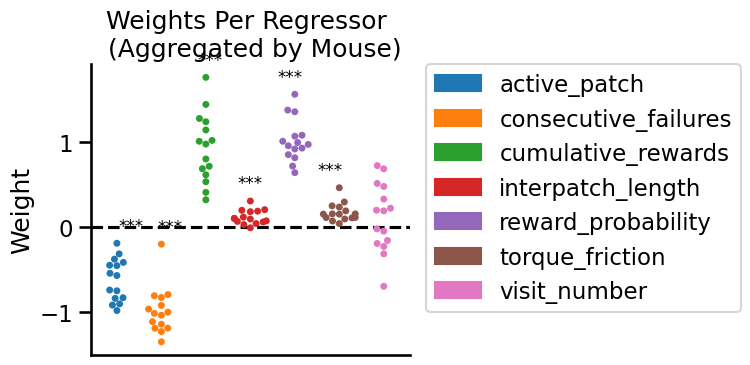

In [317]:
# Aggregate the weights by mouse and regressor
aggregated_df = weights_df.groupby(['mouse', 'regressors'], as_index=False).weights.mean()

# Perform t-tests on the aggregated data
t_test_results = []
for regressor in aggregated_df['regressors'].unique():
    regressor_data = aggregated_df[aggregated_df['regressors'] == regressor]['weights']
    t_stat, p_value = ttest_1samp(regressor_data, 0)
    
    # Determine the significance level
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.05:
        significance = '*'
    else:
        significance = None

    t_test_results.append({'regressor': regressor, 'p_value': p_value, 'significance': significance})

t_test_results_df = pd.DataFrame(t_test_results)

# Plot
plt.figure(figsize=(8, 4))

# One point per mouse
sns.swarmplot(
    data=aggregated_df, 
    x='regressors', 
    y='weights', 
    hue='regressors', 
    palette='tab10', 
    dodge=True
)

# Annotate significance levels
for i, row in t_test_results_df.iterrows():
    regressor = row['regressor']
    significance = row['significance']
    if significance:
        x = list(aggregated_df['regressors'].unique()).index(regressor)
        y = aggregated_df[aggregated_df['regressors'] == regressor]['weights'].max() + 0.1
        plt.text(x, y, significance, ha='center', va='bottom', fontsize=12, color='black')

# Add horizontal line at 0
plt.axhline(0, color='black', linestyle='--')

# Customize labels and legend
plt.xlabel('')
plt.xlim(-1, len(aggregated_df['regressors'].unique()))
plt.ylabel('Weight')
plt.xticks([])
plt.title('Weights Per Regressor \n (Aggregated by Mouse)')

# Manually create legend
handles = []
for regressor, color in zip(aggregated_df['regressors'].unique(), sns.color_palette('tab10', len(aggregated_df['regressors'].unique()))):
    handles.append(mpatches.Patch(color=color, label=regressor))
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
sns.despine()
plt.show()

fig.savefig(os.path.join(results_path, f'weights_all_small_model_{epoch}.pdf'), bbox_inches='tight')

### **Fit odor_labels separately**

In [ ]:
summary_df = load()
features = ['reward_probability', 'consecutive_failures', 'visit_number', 'cumulative_rewards', 'active_patch']

In [283]:
epoch = 'control'
summary_df = summary_df.loc[(summary_df.experiment == epoch)&(summary_df.label == 'RewardSite')]

In [ ]:
metrics_list = []
new_mouse_df = pd.DataFrame()

# Initialize dataframes to store weights and cross-validation results
weights_df = pd.DataFrame(columns=['regressors', 'weights', 'mouse', 'session'])
cv_results_df = pd.DataFrame(columns=['mouse', 'cv_score'])
for odor_label in ['Alpha-pinene', 'Methyl Butyrate']:
    for (mouse, session), mouse_df in summary_df.loc[summary_df.odor_label == odor_label].groupby(['mouse', 'session']):
        print(f"Mouse: {mouse}, Session: {session}")
        mouse_df['total_sites'] = np.arange(1, len(mouse_df)+1)
        
        # Filter data for the current mouse
        
        # Select features and target variable
        X_mouse = mouse_df[features]
        y_mouse = mouse_df['has_choice'].astype(int)
        
        # Standardize the features
        scaler = StandardScaler()
        X_mouse_scaled = scaler.fit_transform(X_mouse)

        # Perform grid search to find the best value for C
        # best_C = grid_search(X_mouse_scaled, y_mouse)
        best_C=1
        
        if len(X_mouse_scaled) < 10:
            continue
        
        # Perform 5-fold cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True)  # random_state ensures reproducibility
        log_reg = LogisticRegression(C=best_C, class_weight='balanced')
        cv_scores = cross_val_score(log_reg, X_mouse_scaled, y_mouse, cv=cv, scoring=scoring)
        
        # Fit the logistic regression model using formula
        log_reg.fit(X_mouse_scaled, y_mouse)

        # Predict class labels (0 or 1)
        y_pred = log_reg.predict(X_mouse_scaled)
        mouse_df['y_pred'] = y_pred
        
        y_probs = log_reg.predict_proba(X_mouse_scaled)[:, 1]
        mouse_df['y_pred_prob'] = y_probs
        
        best_threshold = plotting_roc_curve(y_probs, y_mouse)
        
        y_pred_adjusted = (y_probs >= best_threshold).astype(int)
        mouse_df['y_pred_adjusted'] = y_pred_adjusted
        
        best_thresholds.append(best_threshold)
        
        metrics_list = calculate_metrics(metrics_list, y_mouse, y_pred_adjusted)

        # Get the weights for each feature
        feature_weights = pd.Series(log_reg.coef_[0], index=features)
        feature_weights = feature_weights.reset_index()
        feature_weights.rename(columns={'index': 'regressors', 0: 'weights'}, inplace=True)
        feature_weights['mouse'] = mouse
        feature_weights['session'] = session
        feature_weights['odor_label'] = odor_label
        
        # Save the standard deviation of the cv_scores
        cv_score_std = np.std(cv_scores)
        
        # Append the weights and cv scores to the respective dataframes
        weights_df = pd.concat([weights_df, feature_weights], ignore_index=True)
        cv_results_df = pd.concat([cv_results_df, pd.DataFrame({'odor_label': [odor_label], 
                                                                'session': [session], 'mouse': [mouse],  'cv_std' : [cv_score_std], 
                                                                'cv_score': [cv_scores.mean()]})], ignore_index=True)

        # Print the cross-validation scores and their mean
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean cross-validation score: {cv_scores.mean():.2f}")
        print('\n')
        
        # # Get the weights for each feature
        # test = mouse_df.groupby('total_sites').agg({'has_choice': 'mean', 'y_pred_adjusted': 'mean'}).reset_index()
        # test['diff'] = test['y_pred_adjusted'] - test['has_choice']

        # fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})
        # sns.lineplot(data=test, x='total_sites', y='diff', ax=ax[0], color='black')
        # sns.histplot(data=test, x='diff', hue='diff', ax=ax[1])
        # sns.despine()
        # plt.tight_layout()
        # plt.show()
        new_mouse_df = pd.concat([new_mouse_df, mouse_df], ignore_index=True)
metrics_df = pd.DataFrame(metrics_list)
weights_df['mouse'] = weights_df['mouse'].round(0).astype(str)

In [ ]:
from scipy.stats import ks_2samp

# Separate the data by odor_label
alpha_pinene_scores = cv_results_df[cv_results_df['odor_label'] == 'Alpha-pinene']['cv_score'].dropna()
methyl_butyrate_scores = cv_results_df[cv_results_df['odor_label'] == 'Methyl Butyrate']['cv_score'].dropna()

alpha_pinene_std = cv_results_df[cv_results_df['odor_label'] == 'Alpha-pinene']['cv_std'].dropna()
methyl_butyrate_std = cv_results_df[cv_results_df['odor_label'] == 'Methyl Butyrate']['cv_std'].dropna()

# Perform the Kolmogorov-Smirnov test
ks_score_result = ks_2samp(alpha_pinene_scores, methyl_butyrate_scores)
ks_std_result = ks_2samp(alpha_pinene_std, methyl_butyrate_std)

print(f"KS test for cv_score: statistic={ks_score_result.statistic}, p-value={ks_score_result.pvalue}")
print(f"KS test for cv_std: statistic={ks_std_result.statistic}, p-value={ks_std_result.pvalue}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(scoring)
sns.histplot(data=cv_results_df, x='cv_score',  bins=30, hue='odor_label', ax=ax[0], legend=False)
sns.histplot(data=cv_results_df, x='cv_std',  bins=30, hue='odor_label',  ax=ax[1])
plt.tight_layout()
sns.despine()

In [ ]:
# Plot
fig, axes = plt.subplots(1,2, figsize=(14, 4))

for odor_label, ax in zip(['Alpha-pinene', 'Methyl Butyrate'], axes.flatten()):
    # Aggregate the weights by mouse and regressor
    aggregated_df = weights_df.loc[weights_df.odor_label == odor_label].groupby(['mouse', 'regressors'], as_index=False).weights.mean()

    # Perform t-tests on the aggregated data
    t_test_results = []
    for regressor in aggregated_df['regressors'].unique():
        regressor_data = aggregated_df[aggregated_df['regressors'] == regressor]['weights']
        t_stat, p_value = ttest_1samp(regressor_data, 0)
        
        # Determine the significance level
        if p_value < 0.001:
            significance = '***'
        elif p_value < 0.01:
            significance = '**'
        elif p_value < 0.05:
            significance = '*'
        else:
            significance = None

        t_test_results.append({'regressor': regressor, 'p_value': p_value, 'significance': significance})

    t_test_results_df = pd.DataFrame(t_test_results)

    # One point per mouse
    sns.swarmplot(
        data=aggregated_df, 
        x='regressors', 
        y='weights', 
        hue='regressors', 
        palette='tab10', 
        dodge=True, 
        ax=ax
    )

    # Annotate significance levels
    for i, row in t_test_results_df.iterrows():
        regressor = row['regressor']
        significance = row['significance']
        if significance:
            x = list(aggregated_df['regressors'].unique()).index(regressor)
            y = aggregated_df[aggregated_df['regressors'] == regressor]['weights'].max() + 0.1
            ax.text(x, y, significance, ha='center', va='bottom', fontsize=12, color='black')

    # Add horizontal line at 0
    ax.axhline(0, color='black', linestyle='--')

    # Customize labels and legend
    ax.set_xlabel('')
    ax.set_xlim(-1, len(aggregated_df['regressors'].unique()))
    ax.set_ylabel('Weight')
    ax.set_title(f'Weights {odor_label}')
    ax.set_xticklabels([], rotation=45, ha='right')
# Manually create legend
handles = []
for regressor, color in zip(aggregated_df['regressors'].unique(), sns.color_palette('tab10', len(aggregated_df['regressors'].unique()))):
    handles.append(mpatches.Patch(color=color, label=regressor))
plt.legend(handles=handles, title='Features', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
sns.despine()
plt.show()

fig.savefig(os.path.join(results_path, f'weights_all_small_model_{epoch}.pdf'), bbox_inches='tight')

In [ ]:
# Plot using the collapsed data
for odor_label in ['Alpha-pinene', 'Methyl Butyrate']:
    fig, axes = plt.subplots(4, 4, figsize=(20, 14), sharex=True)

    # Perform t-tests and plot significance
    for (mouse, group), ax in zip(weights_df.loc[weights_df.odor_label == odor_label].groupby('mouse'), axes.flatten()):
        # Perform t-test for each regressor in the group
        significant_regressors = []
        for regressor in group['regressors'].unique():
            regressor_data = group[group['regressors'] == regressor]['weights']
            t_stat, p_value = ttest_1samp(regressor_data, 0)
            
            # Determine the significance level
            if p_value < 0.001:
                significance = '***'
            elif p_value < 0.01:
                significance = '**'
            elif p_value < 0.05:
                significance = '*'
            else:
                significance = None

            if significance:
                significant_regressors.append((regressor, regressor_data.max(), significance))

        # Plot the swarmplot
        sns.swarmplot(
            data=group, 
            x='regressors', 
            y='weights', 
            palette='tab10', 
            ax=ax, 
            hue='regressors',
            dodge=True,
            legend=False
        )
        ax.set_title(f'Mouse {mouse}')
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.hlines(0, -0.5, len(group['regressors'].unique()) - 0.5, color='black', linestyle='--')

        # Annotate significant results
        for regressor, max_value, significance in significant_regressors:
            x = list(group['regressors'].unique()).index(regressor)
            y = max_value + 0.05  # Position above max value
            ax.text(x, y, significance, ha='center', va='bottom', fontsize=12, color='black')

    # Manually create the legend
    handles = []
    for regressor, color in zip(weights_df['regressors'].unique(), sns.color_palette('tab10', len(weights_df['regressors'].unique()))):
        handles.append(mpatches.Patch(color=color, label=regressor))

    # Add legend at the bottom with 3 columns
    fig.legend(
        handles=handles,
        bbox_to_anchor=(0.6, 0.05),  # Centered below the figure
        loc='upper center',
        ncol=3,  # Number of columns
        title='Features',
        prop={'size': 12}
    )

    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust()  # Add space at the bottom for the legend
    plt.xticks(rotation=45, ha='right')
    plt.show()
    fig.savefig(os.path.join(results_path, f'weights_per_mouse_small_model_{epoch}_{odor_label}.pdf'), bbox_inches='tight')